<a href="https://colab.research.google.com/github/nepslor/teaching/blob/main/TimeSeriesForecasting/inducing_stationarity.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# 📖 Seasonally adjusted data - an example
The mortality data [recently published](https://www.nature.com/articles/s41597-021-01019-1) by the [Human Mortality Database](https://www.mortality.org/) can be used to explore seasonality in mortality rates as fatalities / 100000 . Mortality rates are known to be seasonal due to temperatures and other weather-related effects (Healy 2003). In the folloing cells we will use STL decomposition to decompose these time series for different countries.




In [1]:
from statsmodels.tsa.seasonal import STL
import pandas as pd
import matplotlib.pyplot as plt
stmf = pd.read_csv("https://www.mortality.org/File/GetDocument/Public/STMF/Outputs/stmf.csv",skiprows=1)

The following code just adds a DatetimeIndex to the data, from the year and the week columns

In [2]:
stmf.index = pd.DatetimeIndex(pd.DatetimeIndex(stmf['Year'].apply(lambda x: '{}-01-01'.format(x), 0)) + pd.to_timedelta( stmf['Week'].apply(lambda x: '{}d'.format(x * 7), 0)))
stmf.head()

,CountryCode,Year,Week,Sex,D0_14,D15_64,D65_74,D75_84,D85p,DTotal,R0_14,R15_64,R65_74,R75_84,R85p,RTotal,Split,SplitSex,Forecast
2015-01-08,AUS,2015,1,m,17.166833,358.833167,250.0,436.0,413.0,1475.0,0.000386,0.002373,0.013133,0.045643,0.127992,0.006484,1,0,0
2015-01-08,AUS,2015,1,f,13.968728,199.031272,183.0,350.0,704.0,1450.0,0.000332,0.001309,0.009350,0.031185,0.125849,0.006289,1,0,0
2015-01-08,AUS,2015,1,b,31.135561,557.864439,433.0,786.0,1117.0,2925.0,0.000360,0.001840,0.011215,0.037832,0.126633,0.006386,1,0,0
2015-01-15,AUS,2015,2,m,17.473384,334.526616,255.0,386.0,422.0,1415.0,0.000393,0.002212,0.013395,0.040409,0.130781,0.006220,1,0,0
2015-01-15,AUS,2015,2,f,11.490405,186.509595,162.0,322.0,675.0,1357.0,0.000273,0.001227,0.008277,0.028690,0.120665,0.005886,1,0,0


Since the data of a given year-week is splitted over multiple lines due to the presence of the sex attribute, we need to define an auxiliary function to get the aggregated value regardless of the sex.

We additionally define a function returning the matrix form of the data: a dataframe whose rows corresponds to the year and columns to the day of observations.

In [3]:
def get_national_obs(data, cc='ITA'):
  """
  Get death rate for a given country
  """
  data = stmf.loc[stmf['CountryCode'] == cc, ['Week', 'Year', 'RTotal']]
  return data.groupby(data.index).sum()['RTotal']

def get_matrix_form(y):
  """
  Get death rate for a given country, in matrix format (year, week)
  """
  y = pd.concat([y, pd.Series(y.index.year, name='Year', index=y.index),
                 pd.Series(y.index.dayofyear, name='Day', index=y.index)], axis=1)
  y = y.loc[(y.Day>7) & (y.Year<2023)]
  return y.pivot(index='Year', columns='Day', values='RTotal').T



<Axes: >

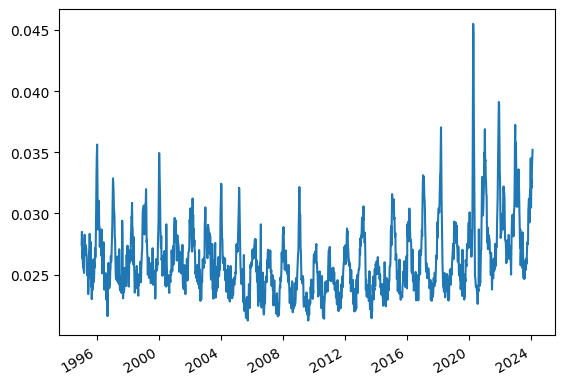

In [13]:
y = get_national_obs(stmf, 'NLD')
y.plot()

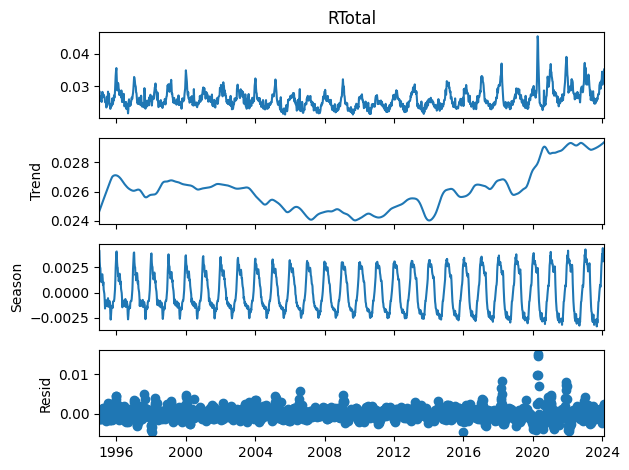

In [15]:
y = get_national_obs(stmf, 'NLD')
stl = STL(y, seasonal=53, period=52)
res = stl.fit()

fig = res.plot()


<Axes: >

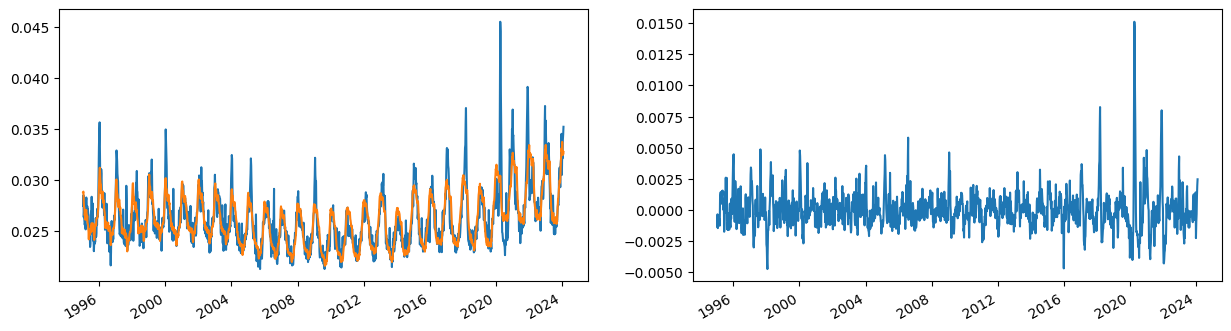

In [16]:
fig, ax = plt.subplots(1, 2, figsize=(15, 4))
res.observed.plot(ax=ax[0])
(res.trend+res.seasonal).plot(ax=ax[0])
(res.resid).plot(ax=ax[1])


Let's have a look at the seasonal plot of the time series

Text(0.5, 1.0, 'seasonal plot')

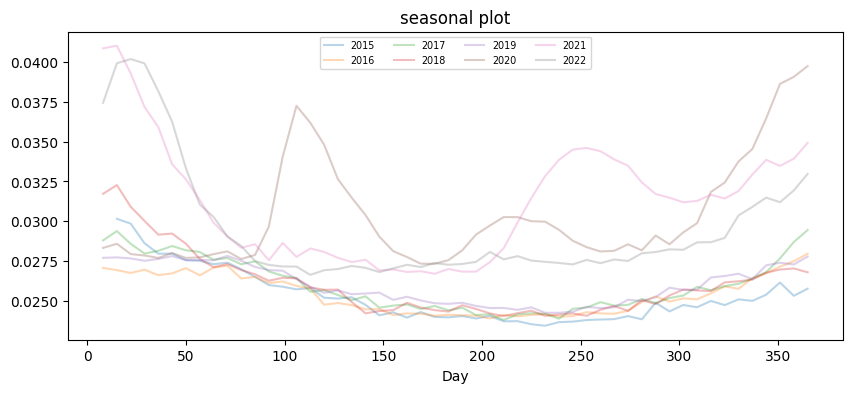

In [26]:
y_mat = get_matrix_form(get_national_obs(stmf,cc='USA'))

fig, ax = plt.subplots(1, 1, figsize=(10, 4))
y_mat.plot(alpha=0.3, ax=ax)
plt.legend(fontsize='x-small', ncol=4)
ax.set_title('seasonal plot')

In [24]:
stmf['CountryCode'].unique()

array(['AUS', 'AUT', 'BEL', 'BGR', 'CAN', 'CHE', 'CHL', 'CZE', 'DEUTNP',
       'DNK', 'ESP', 'EST', 'FIN', 'FRATNP', 'GBRTENW', 'GBR_NIR',
       'GBR_SCO', 'GRC', 'HRV', 'HUN', 'ISL', 'ISR', 'ITA', 'KOR', 'LTU',
       'LUX', 'LVA', 'NLD', 'NOR', 'NZL_NP', 'POL', 'PRT', 'RUS', 'SVK',
       'SVN', 'SWE', 'TWN', 'USA'], dtype=object)

### ❓Write a simple seasonal-trend decomposition
A simple seasonal-trend decomposition can be achieved using the following method:
1. trend: use a lagged moving average of the original signal
2. seasonal: median season of the detrended signal

you can use the `get_matrix_form` and `get_national_obs` functions to do this.

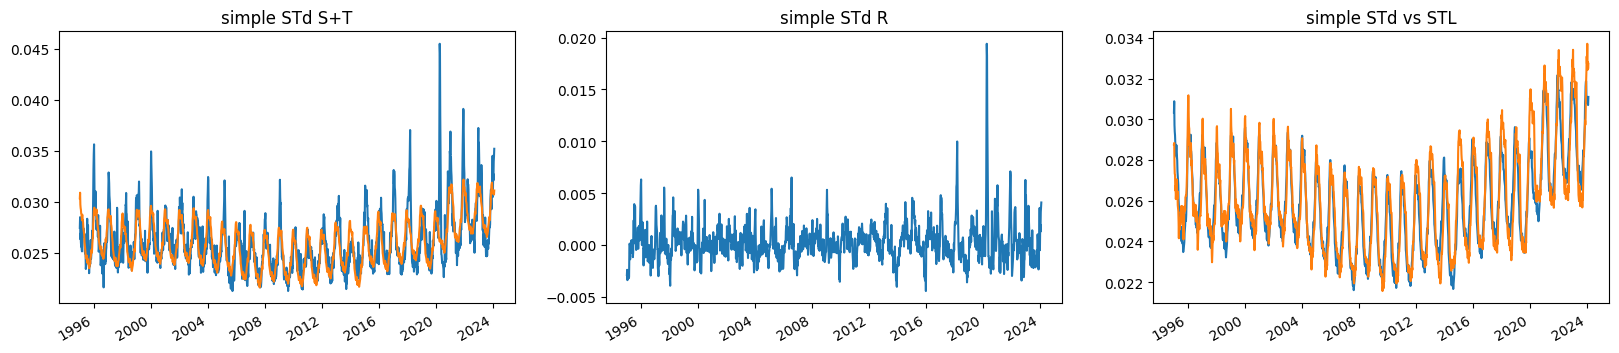

In [44]:
import numpy as np

lagged_mav = lambda x, k: x.rolling('{}d'.format(k)).mean()

def simple_std(stmf, cc='NLD'):
  """
  A simple function that returns trend and seasonal component. The trend is
  obtained using the lagged_mav function, while the seasonal component is the
  daily median of the detrended profile.
  """
  y = get_national_obs(stmf,cc=cc)
  trend = lagged_mav(y, int(365))
  y_mat = get_matrix_form(y-trend)
  season = y_mat.median(axis=1)
  y_seasonal = pd.Series(np.tile(season.values, y_mat.shape[0])[:len(y)], index=y.index)
  return trend, y_seasonal

trend, y_seasonal = simple_std(stmf, cc='NLD')


fig, ax = plt.subplots(1, 3, figsize=(20, 4))
y.plot(ax=ax[0])
(y_seasonal+trend).plot(ax=ax[0])
(y-y_seasonal-trend).plot(ax=ax[1])
(trend + y_seasonal).plot(ax=ax[2])
(res.trend + res.seasonal).plot(ax=ax[2])
ax[0].set_title('simple STd S+T')
ax[1].set_title('simple STd R')
ax[2].set_title('simple STd vs STL');

# Forecasting with STL decomposition
Given the STL decomposiion
$$y_t=S_t+T_t+R_t$$
we can assume that the seasonal component is slow changing, and repeats itself almost exactly. This means that we can use the seasonal naive method we've seen in the last lesson to forecast the seasonal component and then use a forecasting model to just predict $T_t+R_t$.
$$
\begin{align}
\hat{y}_{T+h}&= \hat{S}_{T+h} + f(T_T+R_T) \qquad \ \text{forecasting model + seasonal forecast}\\
\hat{S}_{T+h}&=\hat{S}_{T-k} \qquad\qquad\qquad\qquad \text{seasonal naive}
\end{align}
$$

where $k=m-h+m\lfloor(h-1) / m\rfloor$

\\
<div>
<img src="https://raw.githubusercontent.com/nepslor/teaching/main/TimeSeriesForecasting/figs/Baregg_tunnel.png" width="400" align="right"/>
</div>

Tunnel Traffic is a time series describing the number of vehicles traveling through the Baregg Tunnel in Switzerland each day from November 2003 to November 2005.




            NumVehicles
Day                    
2003-11-01       103536
2003-11-02        92051
2003-11-03       100795
2003-11-04       102352
2003-11-05       106569


<Axes: xlabel='Day'>

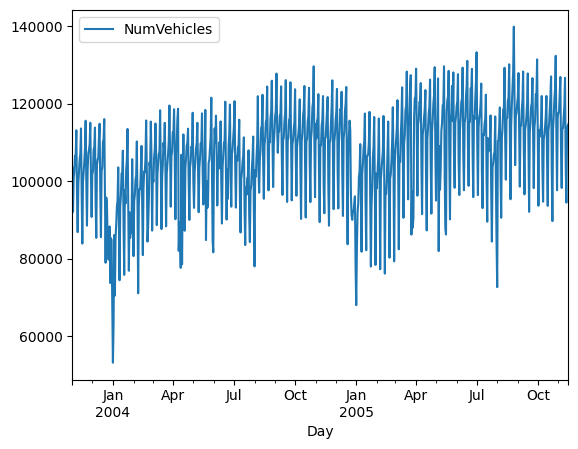

In [45]:
data = pd.read_csv('https://raw.githubusercontent.com/nepslor/teaching/main/TimeSeriesForecasting/data/tunnel.csv', parse_dates=True, index_col=0)
print(data.head())
data.plot()

We start by decomposing the data with the STL and plotting it

<Axes: xlabel='Day'>

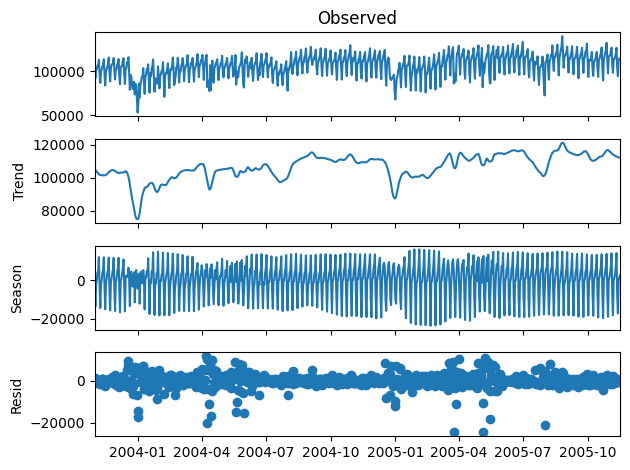

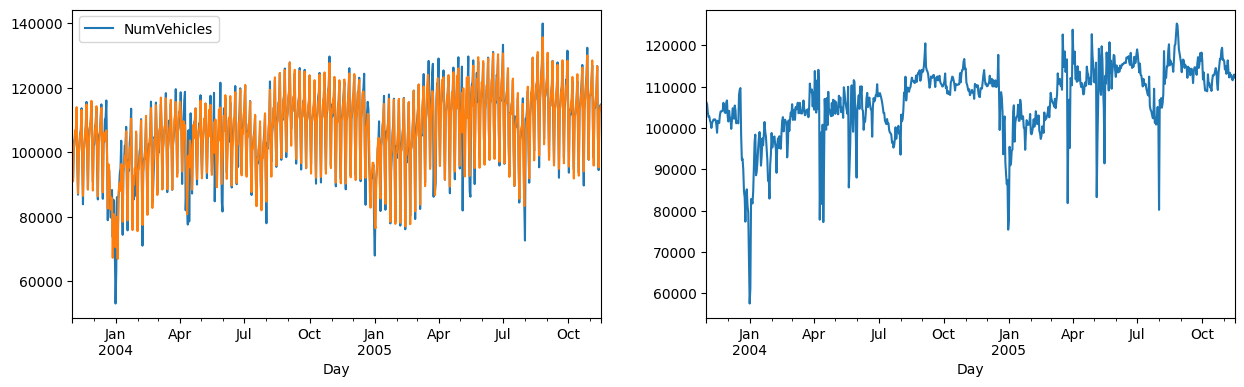

In [46]:
stl = STL(data, seasonal=7)
res = stl.fit()

fig = res.plot()
fig, ax = plt.subplots(1, 2, figsize=(15, 4))
res.observed.plot(ax=ax[0])
(res.trend+res.seasonal).plot(ax=ax[0])
(res.trend+res.resid).plot(ax=ax[1])

### Simple linear forecaster
In the following, we have defined a simple linear forecaster for a univariate time series. The forecaster retrieves the embedding matrix $E(e)$:
$$E(e) = \left[\begin{array}{cccc}x(t-m) &\cdots &x(t) &\cdots x(t+f)\\
x(t-m+1) &\cdots &x(t+1) &\cdots x(t+f+1)\\
\ldots & \ldots & \cdots & \cdots\\
x(T-m-f) &\cdots &x(T-f) &\cdots x(T) \end{array}\right]=[X, Y]$$
where $e = m + f$ and $m$ and $f$ are the number of past steps used as features and the number of steps ahead to be forecasted, respectively.

The forecaster is then fitted as:
$$\theta = (X_{tr}^T X_{tr})^{-1}X_{tr}^T Y_{tr}$$
and predicts through
$$\hat{y} = X_{te}\theta$$



❓ In the following cell we have defined a LinearForecaster class. Try to complete the fit method with the values of x and target, using the get_hankel function.

In [ ]:

def get_hankel(df, embedding=3):
  return pd.concat([df.shift(-l) for l in range(embedding)], axis=1).iloc[:-embedding]


class LinearForecaster:
  """
  A simple linear forecaster: retrieves the signal's Hankel matrix of
  the requested embedding and fits a linear regression on future values.
  """
  def __init__(self, steps_ahead=1, embedding=3):
    self.steps_ahead = steps_ahead
    self.embedding = embedding
    self.theta = None
    self.mean = None
    self.std = None

  def fit(self, y0):
    y = y0.copy()
    self.mean = np.array(y.mean())
    self.std = np.array(y.std())
    x = 0
    target = 0
    self.theta = np.linalg.pinv(x.T@x)@(x.T@target)
    return self

  def predict(self, df):
    x = df.iloc[-self.embedding:].values.reshape(1, -1)/self.std-self.mean
    preds = x @ self.theta
    return pd.DataFrame(preds.ravel(), index=df.iloc[-self.steps_ahead:].index + pd.to_timedelta('{}d'.format(self.steps_ahead)), columns=['y_hat_lin'])



### ❓Write a STL decomposition forecaster
In the followin, try to complete the fit method of the STLLinearForecaster class

In [ ]:

class STLLinearForecaster:
  def __init__(self, steps_ahead=13, linear_embedding=3):
    self.seasonality = steps_ahead
    self.linear_embedding = linear_embedding
    self.rt_model = LinearForecaster(steps_ahead=steps_ahead, embedding=linear_embedding)
    self.seasonal_component = None

  def fit(self, df):
    # STL decomposition of the signal

    # Linear model fit

    return self

  def predict(self, df):
    s_t = self.seasonal_component.iloc[-self.seasonality:]
    rt_t = self.rt_model.predict(df)
    return pd.DataFrame(s_t.values + rt_t.values.ravel(), index=df.iloc[-self.seasonality:].index + pd.to_timedelta('{}d'.format(self.seasonality)), columns=['y_hat_stl'])

the following cell computes a 30 folds cross validation of the linear and STL-linar forecasters

In [ ]:
def cross_validation(*models, steps_ahead=7, embedding=7, do_plot=False):

  forecasters = [m(steps_ahead=steps_ahead, embedding=embedding) for m in models]
  names = [m.__name__ for m in models]
  nmae = lambda x, y: np.mean(np.abs(x - y)) / np.mean(np.abs(y))


  scores = {}
  for i in range(30):
      k = 7 * i + 7 * 30
      data_tr, data_te = data.iloc[:k], data.iloc[k:k + steps_ahead]
      preds = {n: f.fit(data_tr).predict(data_tr) for n, f in zip(names, forecasters)}
      scores[i] = {n: nmae(data_te.values, p.values) for n, p in preds.items()}
      if do_plot:
        fig, ax = plt.subplots(1, 1)
        data_te.plot(ax=ax)
        data.iloc[k - 7 * 6:k].plot(ax=ax)
        [p.plot(ax=ax) for p in preds.values()]

  return pd.DataFrame(scores).mean(axis=1)

cross_validation(LinearForecaster, STLLinearForecaster, do_plot=True)

# Memory of the process
We have just seen that the performances of the STL-linear forecaster are better then the vanilla linear forecaster, if we take the past embedding equal to the step ahad to be forecasted (7 in this case).
Since this embedding is a common parameter to both the models, we can wonder what happens if we increase it.

❓ Try to systematically increase the embedding and the linear_embedding paraeters invoking `cross_validation` and see if the performance goes as expected.



# Inducing stationarity via lagged MA

Why does the performance decreases badly at increasing embeddings for the `STLLinearForecaster`?

The only part of the `STLLinearForecaster` model affected by the embedding time is the linear part, which is forecasting the T+R part. If we plot T+R, we can see that there's little hope that the linear model will benefit from an increasing learning horizon. This can better seen plotting its ACF.

On the other hand, a good idea to obtain a forecastable stationary signal, would be to use a lagged MA. We can then forecast the detrended signal and just add the last value of the MA to get the final prediction. In the next cell we see the difference in the ACF functions for the signals to be forecasted by the two aforementioned strategies.



In [ ]:
import statsmodels.api as sm

seasonality = 7
trend = lagged_mav(data, seasonality)


fig, ax = plt.subplots(2, 2 , figsize=(20, 8))

# plot Trend and Residuals from STL decomposition, along with its ACF
(res.trend+res.resid).plot(ax=ax[0, 0], title='T+R')
_ = sm.graphics.tsa.plot_acf(res.trend+res.resid, lags=40, ax=ax[0, 1], title='T+R ACF')

# plot the signal detrended with the lagged MAV and its ACF
(data-trend).plot(ax=ax[1, 0], title='detrended with lagged MAV')
_ = sm.graphics.tsa.plot_acf(data-trend, lags=40, ax=ax[1, 1], title='detrended with lagged MAV ACF')

The following code defines a linear forecaster that applies a lagged MA detrend before fitting the model


In [ ]:
class LinearDetrendedForecaster:
  def __init__(self, steps_ahead=13, embedding=3):
    self.steps_ahead = steps_ahead
    self.embedding = embedding
    self.rt_model = LinearForecaster(steps_ahead=steps_ahead, embedding=embedding)

  def fit(self, df):
    # signal detrending
    trend = lagged_mav(df, self.steps_ahead)
    self.rt_model.fit(df-trend)
    return self

  def predict(self, df):
    trend = lagged_mav(df, self.steps_ahead)
    y_hat = self.rt_model.predict(df-trend) + trend.iloc[-1].values
    y_hat.name = 'lin_detrended'
    return y_hat

In [ ]:
results = pd.concat({i*7:cross_validation(LinearForecaster, STLLinearForecaster, LinearDetrendedForecaster, embedding=7*i) for i in range(1, 5)}, axis=1)
results.T.plot()
plt.ylabel('nMAE');

# Forecasting by whitening
Another powerful method to forecast a time series is to try to make it uncorrelated and iid by applying a composition of (deterministic) invertible transformations. For example, in this case, we can try to apply the following transformations:

$$x^* = \underbrace{\mathcal{Q}(\underbrace{\Delta_1 \underbrace{\Delta_7(\underbrace{x-M A(x, 7)}_{\text {detrend}})}_{\text {de-seasonalize}})}_{\text {de-correlate}}}_{\text{normalize dist. by optimal transport}}$$

where $MA(x, 7)$ is the (lagged) moving average, $\Delta_k$ are the discrete differencing operators of order $k$ and $\mathcal{Q}$ is quantile transform.
We can see in the following cell how each of this transformations act on the time series, its distribution and on the auto correlation.

In [ ]:
import scipy.stats as stats
from scipy.interpolate import PchipInterpolator

class QTransform:

  def __init__(self, n_points=100):
    self.n_points = n_points
    self.cdf = None
    self.cdf_inv = None

  def fit(self, df):
    # define a grid on the domain of the data
    alphas = np.quantile(df_ds, np.linspace(0.001, 1, self.n_points)).ravel()
    # empirical CDF on the grid
    cdf_points = np.array([(df<alpha).mean()[0] for alpha in alphas]) + np.linspace(0, 1e-10, self.n_points)
    # ECDF function from the data
    self.cdf = PchipInterpolator(alphas, cdf_points)
    # inverse ECDF function from the data
    self.cdf_inv = PchipInterpolator(cdf_points, alphas)
    return self

  def transform(self, df):
    # x* = phi^{-1}(F(x)) = phi^{-1}(U) ~ Normal(0, 1)
    return stats.norm.ppf(self.cdf(df.values))

  def backtransform(self, df):
    # F^{-1}(phi(x*)) = F^{-1}(U) ~ x
    return self.cdf_inv(stats.norm.cdf(df))

# detrended signal
df = data-trend

# detrended, de-seasonalized increments
df_ds =(df-df.shift(7)).dropna()
df_ds = (df_ds-df_ds.shift(1)).dropna()

# normalized detrended, de-seasonalized increments
qt_transform = QTransform().fit(df_ds)
df_ds_qt = qt_transform.transform(df_ds)
df_ds_qt = pd.DataFrame(df_ds_qt, index=df_ds.index)

fig, ax = plt.subplots(4, 3, figsize=(15, 10))

# distributions plots
data.hist(bins=20, ax=ax[0, 0], density=True)
df.hist(bins=20, ax=ax[1, 0], density=True)
df_ds.hist(bins=20, ax=ax[2, 0], density=True)
df_ds_qt.hist(bins=20, ax=ax[3, 0], density=True)

# TS plots
data.iloc[-300:].plot(ax=ax[0, 1])
df.iloc[-300:].plot(ax=ax[1, 1])
df_ds.iloc[-300:].plot(ax=ax[2, 1])
df_ds_qt.iloc[-300:].plot(ax=ax[3, 1])

# ACF plots
_ = sm.graphics.tsa.plot_acf(data, lags=40, ax=ax[0, 2], title='Original data')
_ = sm.graphics.tsa.plot_acf(df, lags=40, ax=ax[1, 2], title='detrended with lagged MAV')
_ = sm.graphics.tsa.plot_acf(df_ds, lags=40, ax=ax[2, 2], title='detrended with lagged MAV, deseasonalized')
_ = sm.graphics.tsa.plot_acf(df_ds_qt, lags=40, ax=ax[3, 2], title='detrended with lagged MAV, deseasonalized')

# Add a normal Gaussian PDF on the QT-transformed signal
x = np.linspace(-3,3, 100)
ax[3, 0].plot(x, stats.norm.pdf(x, 0, 1))

Let's define a forecaster using this whitening process. In this specific case, this forecaster is even simpler than the vanilla linear model, since has just two parameters: the lag of the MA operator and the seasonality. In this case they are identical and set to 7.

The mechanism is the following:
* apply the above transformations on the training set, obtaining the whitened variable x* and store it
* at prediction time, draw several random samples from x* and apply the inverse transformation

This process generates several prediction scenarios, which chan be averaged to obtain a point forecast.

### ❓ Complete the following forecaster
Try to complete the fit method for the following forecaster


In [ ]:
class StationarityForecaster:
  def __init__(self, **kwargs):
    self.qt_transform = None

  def fit(self, df):
    # detrend the signal with a MA
    #df = ?                               # complete this line
    # de-seasonalize
    #df_ds =?                             # complete this line
    # obtain first order differences
    #df_ds_diff = ?                       # complete this line
    # apply quantile transform
    #df_ds_diff = ?                       # complete this line
    # store scenarios of the same lenght of the prediction of the transformed variable x*
    nmax = np.floor(df_ds_diff.shape[0]/7).astype(int)*7
    self.noise_scenarios = df_ds_diff[-nmax:].reshape(7, -1)
    return self

  def predict(self, df, scenarios=False):
    # sample stored x* scenarios
    scens = self.noise_scenarios[:, np.random.choice(self.noise_scenarios.shape[1], 400)]
    # backtransform the distribution
    scens = self.qt_transform.backtransform(scens.T.ravel()).reshape(7, -1)
    # integrate
    scens = np.cumsum(scens, axis=0)
    # add seasonality
    scens = scens + df.values[-7:]
    if scenarios:
      return pd.DataFrame(scens, index=df.iloc[-7:].index + pd.to_timedelta('{}d'.format(7)))
    return pd.DataFrame(np.mean(scens, axis=1), index=df.iloc[-7:].index + pd.to_timedelta('{}d'.format(7)),columns=['StationarityForecaster'])

results = pd.concat({i*7:cross_validation(LinearForecaster, STLLinearForecaster, LinearDetrendedForecaster, StationarityForecaster,  embedding=7*i) for i in range(1, 5)}, axis=1)
results.T.plot(figsize=(5, 4))
plt.ylabel('nMAE');

In [ ]:
fig, ax = plt.subplots(1, 1, figsize=(15, 5))
data.iloc[-100:].plot(ax=ax)
StationarityForecaster().fit(data).predict(data, scenarios=True).plot(color='r', alpha=0.05, legend=False, ax=ax)